# Convolutional Neural Network for Time Series
---

The idea is that the window of previous values defines as a ***picture*** the state of the process at a given time.  

Therefore, we use *image recognition*, as we want to find patterns that map pictures to the response value. We include in our timeseries.py a new function, ```WindowsToPictures()```.  

This functions takes the windows that we have been using as inputs, and creates a picture with all previous values of a *window length* of all the columns, for each value in the response.  

If we remember the reshaping to windows in the chapter 1, this time, the windows won't be flatten. Instead, they will be stacked in the third dimension of a 3D tensor, where each *slice* will be a picture to map with a unique response value. Here is an ilustration:
<img src='./Images/cnn_stacked_windows.png'>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 20 08:56:58 2018
@author: pablorr10

Convolutional Layer to Process windows of minute-wise granularity information
about the process parameters per Temperature Reading.
Output of the CL will feed a Dense Layer that will output the value of Tplus2
"""

import copy as cp
import numpy as np
import pandas as pd
import timeseries as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from beautifultable import BeautifulTable as BT

# Keras Implementation
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D


Package Imported! ;)


Using TensorFlow backend.


(155, 5, 5)


<function matplotlib.pyplot.show>

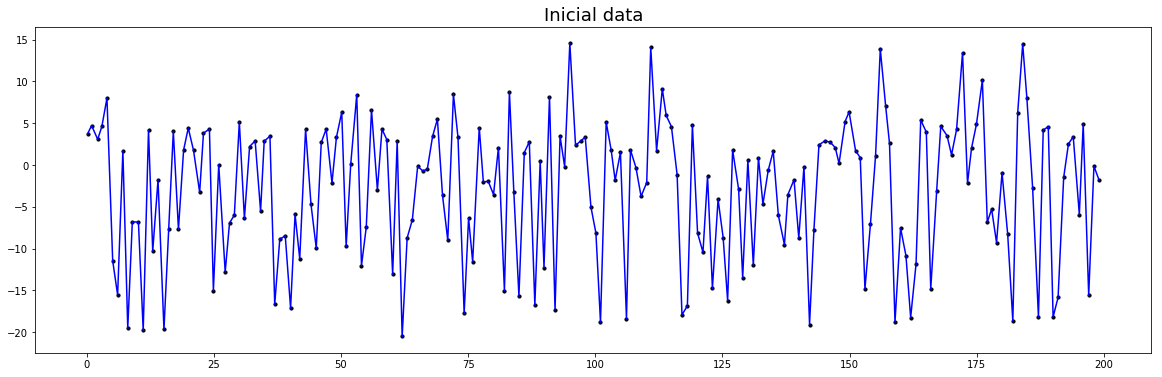

In [2]:
##############################################################################
# IMPORT DATA AND WINDOWS
##############################################################################
path_to_data = './windows_ts.h5'
dataset = pd.read_hdf(path_to_data, 'dataset')
CNN_trainset = pd.read_hdf(path_to_data, 'trainset')
CNN_testset = pd.read_hdf(path_to_data, 'testset')

cnn_trainset = cp.deepcopy(CNN_trainset)
cnn_testset = cp.deepcopy(CNN_testset)

scaler = MinMaxScaler()
yscaler = MinMaxScaler()
cnn_trainset.iloc[:,1:-1] = scaler.fit_transform(CNN_trainset.iloc[:,1:-1])
cnn_trainset.iloc[:,-1] = yscaler.fit_transform(CNN_trainset.iloc[:,-1].values.reshape(-1,1))
cnn_testset.iloc[:,1:-1] = scaler.transform(CNN_testset.iloc[:,1:-1])
cnn_testset.iloc[:,-1] = yscaler.transform(CNN_testset.iloc[:,-1].values.reshape(-1,1))

w = 5 # observations 
window = w 
train_PictureCreator = ts.WindowsToPictures(window, cnn_trainset.iloc[:,1:-1])
train_tensor = train_PictureCreator.collect_pictures()
test_PictureCreator = ts.WindowsToPictures(window, cnn_testset.iloc[:,1:-1])
test_tensor = test_PictureCreator.collect_pictures()

train_PictureCreator_y_inc = ts.WindowsToPictures(window, cnn_trainset.iloc[:,1:])
train_tensor_y_inc = train_PictureCreator_y_inc.collect_pictures()
test_PictureCreator_y_inc = ts.WindowsToPictures(window, cnn_testset.iloc[:,1:])
test_tensor_y_inc = test_PictureCreator_y_inc.collect_pictures()

#np.save('tensors', preds_tensor)
#preds_tensor = np.load('tensors.npy')

print(train_tensor_y_inc.shape)
plt.figure(figsize=(20,6))
plt.title('Inicial data', fontsize=18)
plt.plot(dataset['t'], dataset['y'], 'b-')
plt.scatter(dataset['t'], dataset['y'], color='black', s=10)
plt.show

This means we have 475 pictures that will define 475 values of the response y.  
Each of this windows is a 5x5 dataframe.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 3, 32)          160       
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 12)          1548      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 2, 12)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
__________

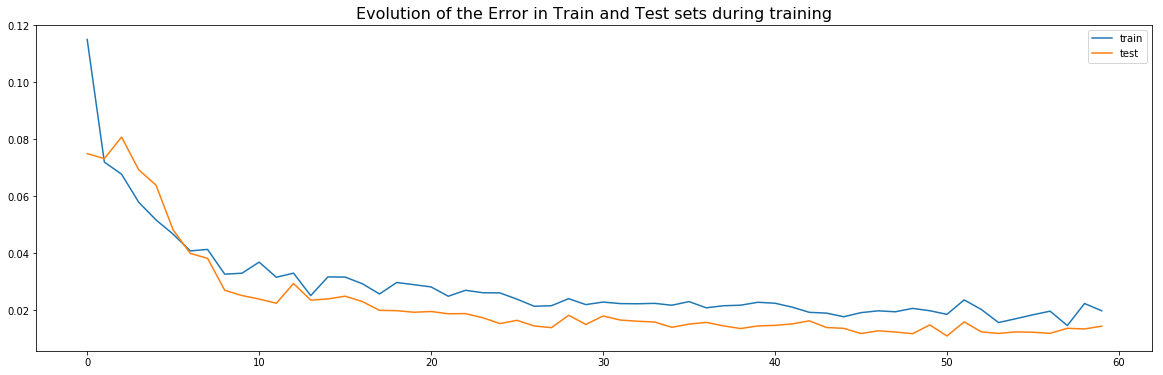

RMSE = 4.21


In [3]:
##############################################################################
# CREATION OF THE MODEL - Without Previous y
##############################################################################        
''' KERAS IMPLEMENTATION'''
trainset = cp.deepcopy(train_tensor)
testset = cp.deepcopy(test_tensor)
# Input format = (samples, rows, cols, channels)
trainset = trainset.reshape(trainset.shape[0], trainset.shape[1], trainset.shape[2], 1)
testset = testset.reshape(testset.shape[0], testset.shape[1], testset.shape[2], 1)

inputs_shape = (trainset.shape[1], trainset.shape[2], 1)

# Research on parameter: Dilation_Rate of the convolution
if 'model' in locals(): del model
if 'history' in locals(): del history

model = Sequential()
model.add(Conv2D(filters = 32, 
                 input_shape = inputs_shape,
                 data_format = 'channels_last',
                 kernel_size=(2,2), 
                 strides=(1,1),   
                 activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(AveragePooling2D(pool_size=(2,1)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 12, 
                 data_format = 'channels_last',
                 kernel_size=(2,2), 
                 strides=(1,1),   
                 activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(45, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

##############################################################################
# TRAIN THE NETWORK AND PREDICT - Without previous y
##############################################################################
X_train = cp.deepcopy(trainset)
y_train = cnn_trainset.iloc[w:,-1].values.reshape(-1,1)
X_test = cp.deepcopy(testset)
y_test = cnn_testset.iloc[w:,-1].values.reshape(-1,1)

table = BT(max_width=3000)
table.column_headers = ['Set', 'Samples', 'TimeWindow(sec)', 'Features', 'Channels']
table.append_row(['trainX', X_train.shape[0], X_train.shape[1], X_train.shape[2], 1])
table.append_row(['trainY', y_train.shape[0], 1, '~', '~'])
table.append_row(['testX',  X_test.shape[0], X_test.shape[1],  X_test.shape[2], 1])
table.append_row(['TestY',  y_test.shape[0], 1, '~', '~'])
print(table)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=60, batch_size=4, verbose=0)

# Plot history of training
plt.figure(figsize=(20,6))
plt.title('Evolution of the Error in Train and Test sets during training', 
          fontsize=16)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

cnn_pred = model.predict(X_test)
cnn_y_pred = yscaler.inverse_transform(cnn_pred)
cnn_residuals = cnn_y_pred - CNN_testset.iloc[w:,-1].values.reshape(-1,1)
cnn_rmse = np.sqrt(np.sum(np.power(cnn_residuals,2)) / len(cnn_residuals))
print('RMSE = %.2f' % cnn_rmse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 4, 32)          160       
_________________________________________________________________
average_pooling2d_2 (Average (None, 2, 4, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 3, 32)          4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 96)                0         
__________

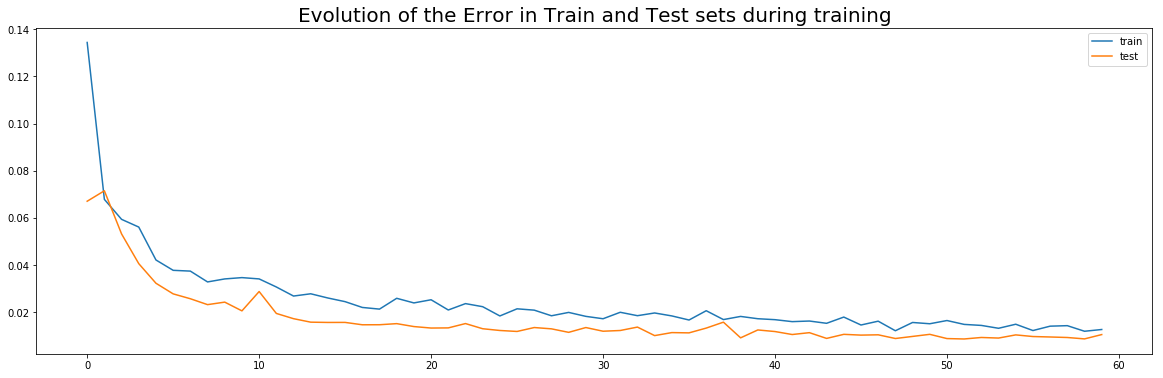

RMSE = 3.59


In [4]:
##############################################################################
# CREATION OF THE MODEL - With Previous y
##############################################################################        
''' KERAS IMPLEMENTATION'''
trainset_y_inc = cp.deepcopy(train_tensor_y_inc)
testset_y_inc = cp.deepcopy(test_tensor_y_inc)
# Input format = (samples, rows, cols, channels)
trainset_y_inc = trainset_y_inc.reshape(trainset_y_inc.shape[0], trainset_y_inc.shape[1], 
                                        trainset_y_inc.shape[2], 1)
testset_y_inc = testset_y_inc.reshape(testset_y_inc.shape[0], testset_y_inc.shape[1], 
                                      testset_y_inc.shape[2], 1)

inputs_shape = (trainset_y_inc.shape[1], trainset_y_inc.shape[2], 1)

# Research on parameter: Dilation_Rate of the convolution
if 'model' in locals(): del model
if 'history' in locals(): del history

model = Sequential()
model.add(Conv2D(filters = 32, 
                 input_shape = inputs_shape,
                 data_format = 'channels_last',
                 kernel_size=(2,2), 
                 strides=(1,1),   
                 activation='relu'))
model.add(AveragePooling2D(pool_size=(2,1)))
#model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, 
                 input_shape = inputs_shape,
                 data_format = 'channels_last',
                 kernel_size=(2,2), 
                 strides=(1,1),   
                 activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

##############################################################################
# TRAIN THE NETWORK AND PREDICT - With previous y
##############################################################################
X_train_y_inc = cp.deepcopy(trainset_y_inc)
y_train_y_inc = cnn_trainset.iloc[w:,-1].values.reshape(-1,1)
X_test_y_inc = cp.deepcopy(testset_y_inc)
y_test_y_inc = cnn_testset.iloc[w:,-1].values.reshape(-1,1)

table = BT(max_width=3000)
table.column_headers = ['Set', 'Samples', 'TimeWindow(sec)', 'Features', 'Channels']
table.append_row(['trainX', X_train_y_inc.shape[0], X_train_y_inc.shape[1], X_train_y_inc.shape[2], 1])
table.append_row(['trainY', y_train_y_inc.shape[0], 1, '~', '~'])
table.append_row(['testX', X_test_y_inc.shape[0], X_test_y_inc.shape[1], X_test_y_inc.shape[2], 1])
table.append_row(['TestY', y_test_y_inc.shape[0], 1, '~', '~'])
print(table)

history = model.fit(X_train_y_inc, y_train_y_inc, validation_data=(X_test_y_inc, y_test_y_inc), 
          epochs=60, batch_size=4, verbose=0)


# Plot history of training
plt.figure(figsize=(20,6))
plt.title('Evolution of the Error in Train and Test sets during training', 
          fontsize=20)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

cnn_pred_y_inc = model.predict(X_test_y_inc)
cnn_y_pred_y_inc = yscaler.inverse_transform(cnn_pred_y_inc)
cnn_residuals_y_inc = cnn_y_pred_y_inc - CNN_testset.iloc[w:,-1].values.reshape(-1,1)
cnn_rmse_y_inc = np.sqrt(np.sum(np.power(cnn_residuals_y_inc,2)) / len(cnn_residuals_y_inc))
print('RMSE = %.2f' % cnn_rmse_y_inc)

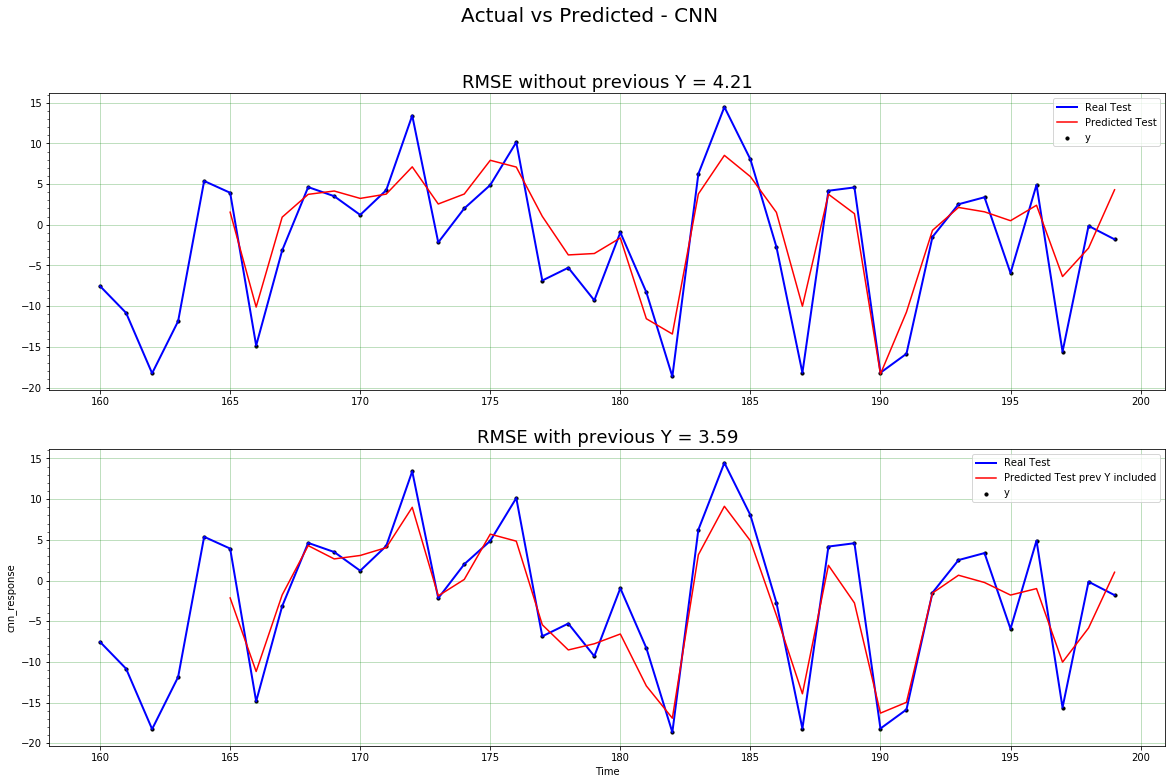

In [5]:
# Plot responses
f, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
plt.suptitle('Actual vs Predicted - CNN' , fontsize=20)
ax1.set_title('RMSE without previous Y = %.2f' % cnn_rmse, fontsize = 18)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.scatter(CNN_testset.index, CNN_testset.y, color='black', s=10)
ax1.plot(CNN_testset.index, CNN_testset.y, linewidth=2, color='b', label='Real Test')
ax1.plot(CNN_testset.index[w:], cnn_y_pred, 
         color='r', label='Predicted Test')

ax2.set_title('RMSE with previous Y = %.2f' % cnn_rmse_y_inc, fontsize = 18)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax2.scatter(CNN_testset.index, CNN_testset.y, color='black', s=10)
ax2.plot(CNN_testset.index, CNN_testset.y, 
         linewidth=2, color='b', label='Real Test')
ax2.plot(CNN_testset.index[w:], cnn_y_pred_y_inc, 
         color='r', label='Predicted Test prev Y included')

ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.legend()
plt.xlabel('Time')
plt.ylabel('cnn_response')
plt.show()

## Conclusion
---

Taking the previous state of a process as a picture of the process for every time step seems like a reasonable approach for multivariate time-series forecasting.  

This approach allows to frame the problem to whatever king of problem, such as financial time-series forecasting, temperature/weather prediction, process variables monitoring...  

I still would like to think about new ways of creating the windows and the pictures to improve the results, but for me it looks like a robust module agains overfitting as we can see in the peaks, it never tends to go beyond the real values.  

I would love to know what you come up with to improve it!  